# Fit atmosphere parameters using wavelet decomposition as input

- author Sylvie Dagoret-Campagne
- creation date : August 19th 2020

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [4]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [5]:
import libatmscattering as atm

In [6]:
all_files=["lsst_atm_10year_wavelets_dataset1.fits",
           "lsst_atm_10year_wavelets_dataset2.fits",
           "lsst_atm_10year_wavelets_dataset3.fits",
           "lsst_atm_10year_wavelets_dataset4.fits",
           "lsst_atm_10year_wavelets_dataset5.fits",
           "lsst_atm_10year_wavelets_dataset6.fits",
           "lsst_atm_10year_wavelets_dataset7.fits",
           "lsst_atm_10year_wavelets_dataset8.fits",
           "lsst_atm_10year_wavelets_dataset9.fits"]

In [7]:
input_file=all_files[2]

In [8]:
hdu = fits.open(input_file)

In [9]:
hdr=hdu[0].header
data=hdu[0].data

In [10]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   20                                                  
NAXIS2  =                 3650                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [11]:
#NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [12]:
num=data[0:,idx_out_num]
year=data[0:,idx_out_year]
airmass=data[0:,idx_out_year]
vaod=data[0:,idx_out_vaod] # vertical aerosol depth
pwv=data[0:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[0:,idx_out_o3]     # ozone
cld=data[0:,idx_out_cld]   # clouds (not used)

In [13]:
coeff=data[:,idx_out_res:]

In [14]:
coeff

array([[ 2.00324219,  1.52381444, -0.09222375, ...,  0.24631883,
        -1.65551047, -0.00520482],
       [ 1.53320036,  1.46361626, -0.19350372, ...,  0.23165237,
        -1.73079587, -0.01709568],
       [ 2.11070673,  1.91002227, -0.18253978, ...,  0.20016853,
        -2.16991793, -0.01065391],
       ...,
       [ 2.16239243,  0.86796922,  0.19323001, ...,  0.32793005,
        -0.71318396,  0.00794895],
       [ 2.20309423,  1.15453053,  0.14201087, ...,  0.29740147,
        -1.10438126,  0.00551588],
       [ 1.88785076,  1.1490328 ,  0.04532459, ...,  0.28472018,
        -1.19548717, -0.00266076]])

In [15]:
N=coeff.shape[1]
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

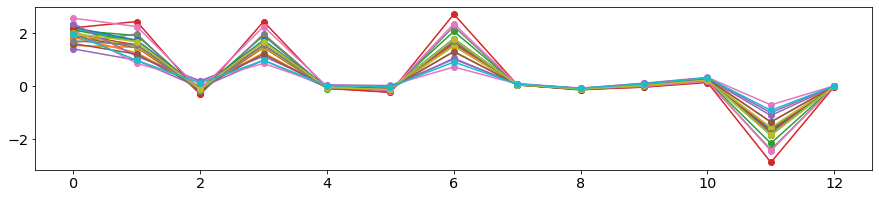

In [16]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
for idx in np.arange(20):
    ax.plot(coeff[idx,:],"o-")

In [17]:
alert False

SyntaxError: invalid syntax (<ipython-input-17-0039b9705ac8>, line 1)

# Prepare data

In [ ]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

### concatenate VAOD,PWV, Ozone

In [ ]:
Y=np.concatenate((vaodarr,pwvarr,o3arr),axis=1)

In [ ]:
X=coeff

## Splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [ ]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [ ]:
FLAG_SCALING=True

In [ ]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

In [ ]:
scaler_X.mean_.shape

In [ ]:
scaler_X.scale_.shape

In [ ]:
scaler_Y.mean_.shape

In [ ]:
scaler_Y.scale_.shape

In [ ]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

In [ ]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50)
ax.set_title("Renormalised target (VAOD, O3, PWV)")

## Linear regression model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [ ]:
reg = linear_model.LinearRegression()

In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


# Linear Regression with Ridge

In [ ]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [ ]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

## Tune hyper parameter with Ridge

In [ ]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

In [ ]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [ ]:
alpha_ridge_min=alphas[idx_min]
alpha_ridge_min

In [ ]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")

idx_min=np.where(all_MSE<5e-9)[0][-1]

alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
alpha_ridge

### Display results

In [ ]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())

In [ ]:
fig=plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(311)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Ridge coefficients as a function of the regularization')

ax2 = fig.add_subplot(312,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(313,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [ ]:
from sklearn import linear_model

In [ ]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [ ]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

In [ ]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -1, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

In [ ]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [ ]:
alpha_lasso_min=alphas[idx_min]
alpha_lasso_min

In [ ]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")

idx_min=np.where(all_MSE==all_MSE.min())[0][0]

alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
alpha_lasso

In [ ]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())

In [ ]:
fig=plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(311)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Lasso coefficients as a function of the regularization')

ax2 = fig.add_subplot(312,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(313,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [ ]:
nb_tot_test=len(Y_test)

In [ ]:
nsamples=np.arange(10,nb_tot_test,10)

### Leraning curves for linear regression

In [ ]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [ ]:
count=0
for n in nsamples:
    
    regr = linear_model.LinearRegression(fit_intercept=True)
  
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    regr.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = regr.predict(X_train_cut)
    Y_pred_test  = regr.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

In [ ]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("Linear Regression - No reg : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax.grid()

### Learning curves for Ridge

In [ ]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [ ]:
alpha_ridge

In [ ]:
alpha_ridge=1e-4

In [ ]:
count=0
for n in nsamples:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    Y_pred_test  = ridge.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

In [ ]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Lasso

In [ ]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [ ]:
alpha_lasso

In [ ]:
alpha_lasso_min

In [ ]:
alpha_lasso_0=1e-3

In [ ]:
count=0
for n in nsamples:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

In [ ]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

# Final

# No regularisation

In [ ]:
regr = linear_model.LinearRegression(fit_intercept=True)
    
if FLAG_SCALING:           
    regr.fit(X_train_scaled,Y_train_scaled)
else:
    regr.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = regr.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = regr.predict(X_test)
    DY=Y_pred_test-Y_test
    

In [ ]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

In [ ]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')
ax.set_xlabel("O3 sim (DbU)")
ax.set_ylabel("O3 pred (DbU)")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (no cloud)",Y=1.1,fontsize=25)

In [ ]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
#ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + No Reg (no cloud)",Y=1.1,fontsize=25)

In [ ]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + No Reg reg, (no cloud)",Y=1.1,fontsize=25)

## Ridge

In [ ]:
ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    
    


In [ ]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

In [ ]:
ridge.coef_

In [ ]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')
ax.set_xlabel("O3 sim (DbU)")
ax.set_ylabel("O3 pred (DbU)")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (no cloud)",Y=1.1,fontsize=25)

In [ ]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (no cloud)",Y=1.1,fontsize=25)

In [ ]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (no cloud)",Y=1.1,fontsize=25)

## Lasso

In [ ]:
#lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

In [ ]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

In [ ]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')
ax.set_xlabel("O3 sim (DbU)")
ax.set_ylabel("O3 pred (DbU)")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (no cloud)",Y=1.1,fontsize=25)

In [ ]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
#ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (no cloud)",Y=1.1,fontsize=25)

In [ ]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (no cloud)",Y=1.1,fontsize=25)